# Explore SVD based word embedding

This notebook explores word embeddings that are based on SVD of a possibly transformed word-context matrix. Starting with the raw matrix `counts`

- possilby transform `counts` (e.g. log data, do PPMI transform, normalize rows)
- compute SVD of new matrix
- explore word embeddings e.g. scores plots, word similarity
- explore loadings

The material in this notebook is covered in chapters 15/16 of SLP3
- https://web.stanford.edu/~jurafsky/slp3/15.pdf
- https://web.stanford.edu/~jurafsky/slp3/16.pdf


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import heapq

from scipy.sparse.linalg import svds, norm
from scipy.sparse import diags, csr_matrix, dok_matrix

# import local code files
import sys, os
sys.path.append(os.getcwd() + '/code/')

# working with word embeddings
from save import load_vocabulary, load_matrix
from ppmi import calc_ppmi
from word_similarity import similarity, closest
from transform_counts import remove_zero_count_words

# exploring/visualizing scores/loadings
from scores_viz import scores_plot, filter_scores
from explore_loadings import top_loading_components, top_loading_words, top_loading_words_df

# only import this if you have plot.ly installed
# from viz_plotly import interactive_scores_plot

%load_ext autoreload
%autoreload 2
%matplotlib inline

/Users/iaincarmichael/anaconda/lib/python2.7/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [2]:
w2i, i2w = load_vocabulary('data/vocab_small_ex.txt')
co_counts = load_matrix('data/co_counts_small_ex')
word_counts = np.load('data/word_counts_small_ex.npy')

In [3]:
co_counts, w2i, i2w = remove_zero_count_words(co_counts, i2w)

# transform counts


In [4]:
# normalized row by row norms
co_counts_normed = diags(1.0/norm(co_counts, axis=1)) * co_counts 

In [7]:
co_counts_log = co_counts
co_counts_log.data = np.log(1 + co_counts.data)

In [8]:
ppmi = calc_ppmi(co_counts)

# SVD of counts matrix

If $X \in \mathbb{R}^{n \times d}$ is a data matrix with the n observations on rows then the rank K SVD is given by
$$X \approx U D V^T$$
where $U \in \mathbb{R}^{n \times K}$ is the matrix of normalized scores and  $V \in \mathbb{R}^{d \times K}$ is the matrix of loadings.

If X is a word-context matrix then U (or UD) gives a word embedding.

In [9]:
%%time
k = 10

normed_scores, sing_vals, loadings =  svds(co_counts_normed, k)

loadings = loadings.T
un_normed_scores = normed_scores * sing_vals

CPU times: user 441 ms, sys: 15.3 ms, total: 456 ms
Wall time: 441 ms


In [10]:
embedding = un_normed_scores

# Explore word embedding (scores)

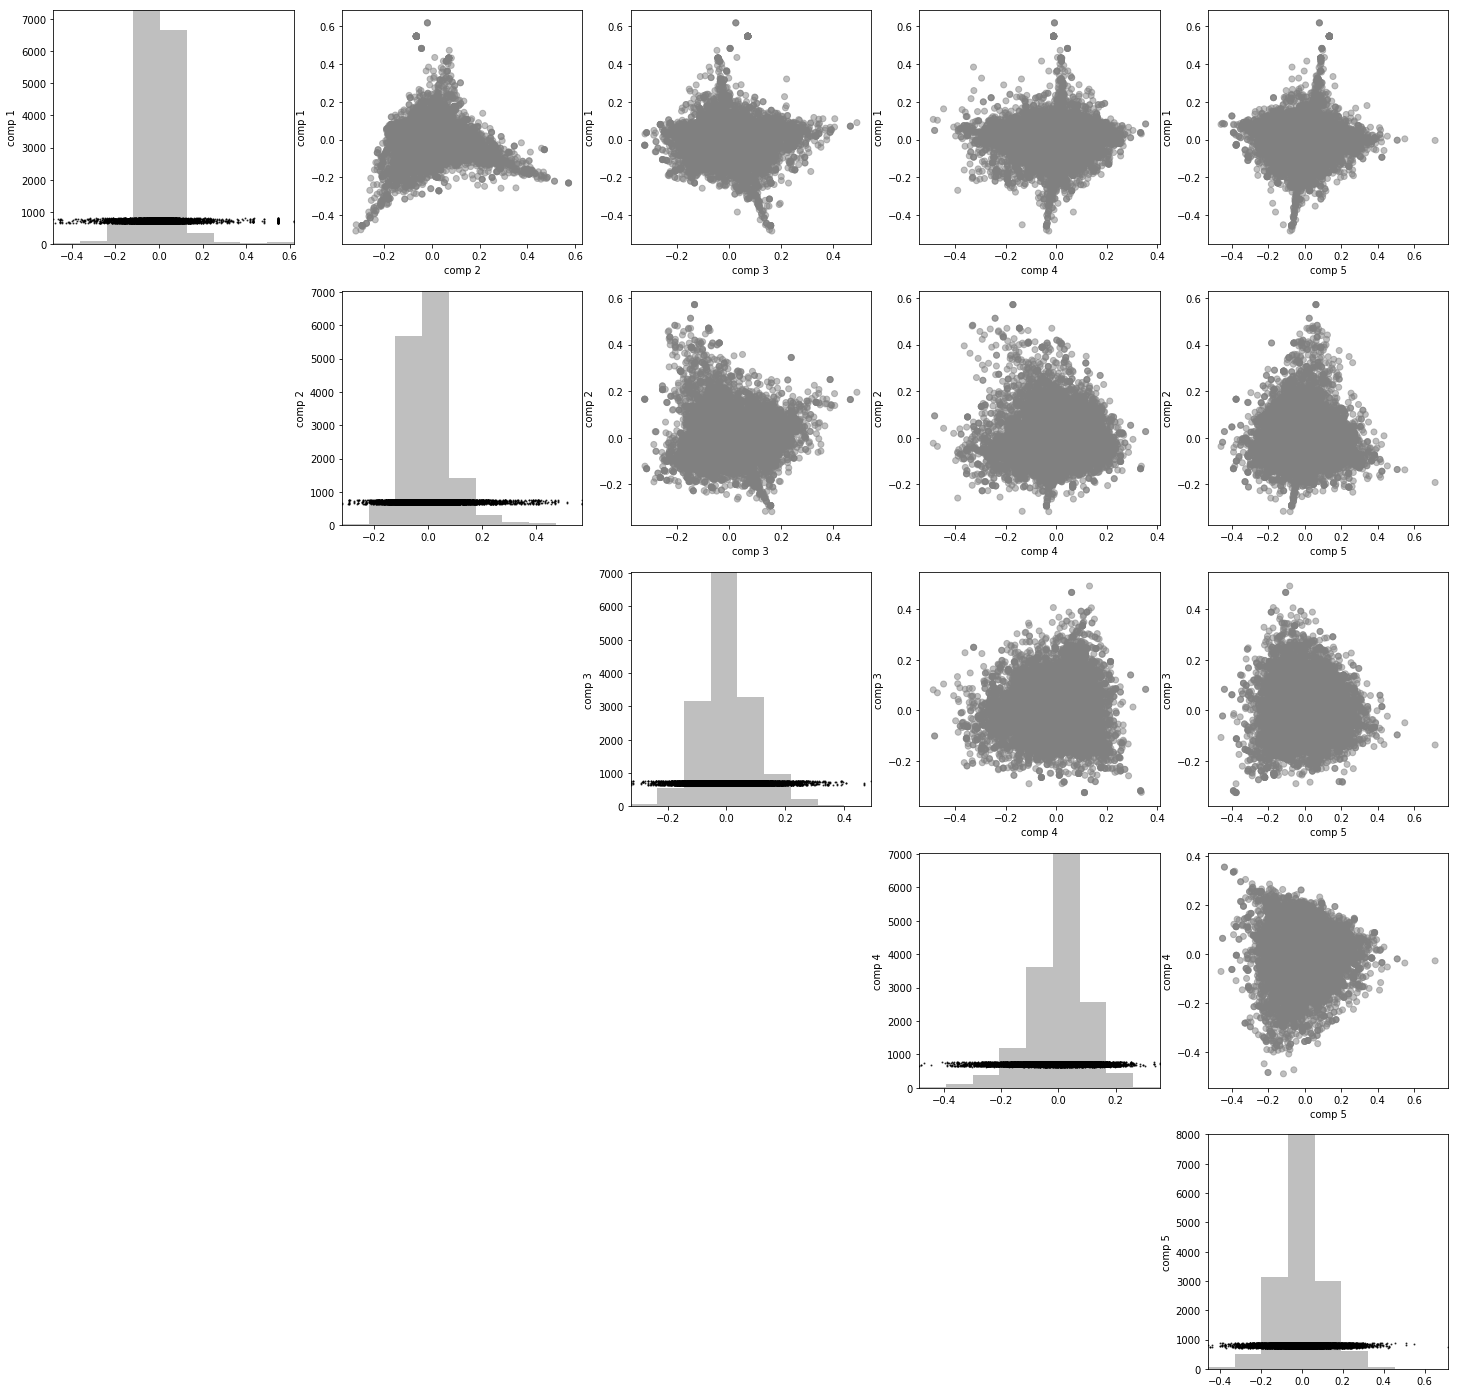

In [11]:
scores_plot(embedding,
            start=1,
            n_comp=5,
            title='',
            comp_names=None)

In [12]:
# this won't run if you don't have plot.ly already installed
# from py_fun_iain.dim_red.viz_plotly import interactive_scores_plot
# interactive_scores_plot(scores,comp1=1, comp2=3, labels=iw)

# simlarity

In [13]:
word1 = 'lawyer'
word2 = 'lawyers'

similarity(word1, word2, embedding, w2i, sim='angle')

21.531365439698661

In [14]:
word = 'lawyer'
closest(word, embedding, w2i, N=10)

['four',
 'pierce',
 'looking',
 'navigating',
 'sprague',
 'virginia\xc2\x97plus',
 'meadows',
 'sinking',
 'foul',
 'woods']

# explore loadings

In [15]:
top_loading_df = top_loading_words_df(loadings, i2w, n=30)

top_loading_df

,1,2,3,4,5,6,7,8,9,10
1,at,or,that,in,to,and,of,to,v,the
2,states,at,a,a,a,of,the,of,us,of
3,united,any,or,or,in,for,a,a,the,to
4,or,is,not,the,that,by,and,that,of,and
5,court,to,and,that,of,is,v,the,states,in
6,see,be,is,for,is,were,us,in,united,a
7,supreme,a,it,is,at,on,or,is,see,that
8,id,in,at,and,and,or,for,it,at,is
9,in,us,the,any,the,general,by,not,co,for
10,that,such,to,it,states,with,to,be,f2d,by


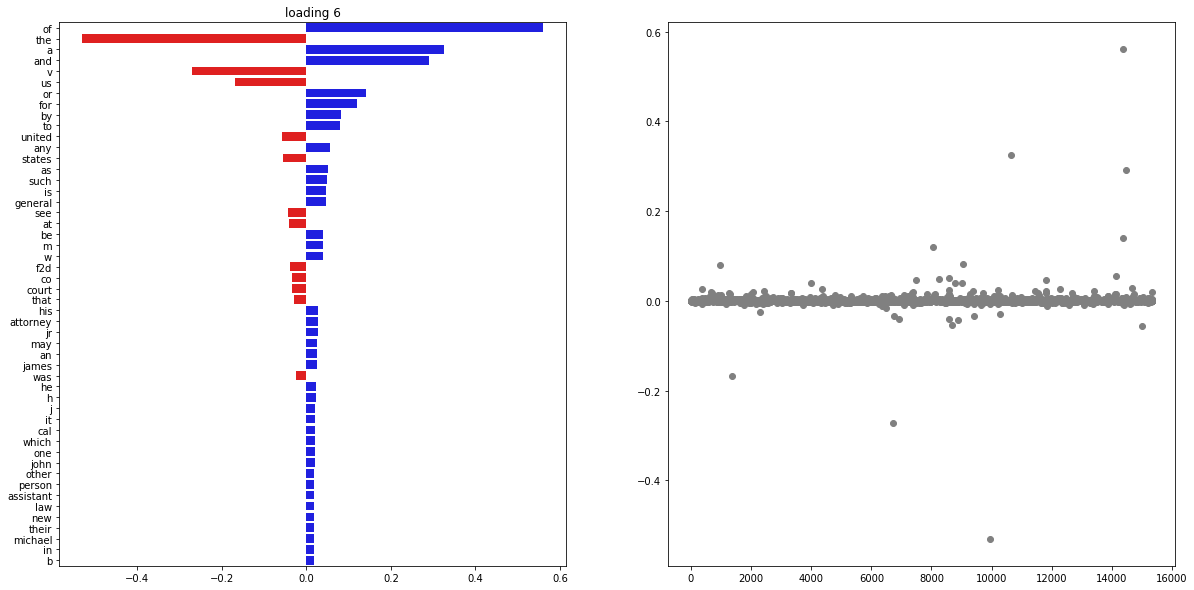

In [16]:
comp_numer = 6  # which loading
n = 50 # how many components to show

plt.figure(figsize=[20, 10])

plt.subplot(1,2,1)
top_loading_components(loadings[:, comp_numer], i2w, n, comp_numer)


plt.subplot(1,2,2)
plt.scatter(range(loadings.shape[0]), loadings[:, comp_numer], color='grey')